# Double and Pseudo Double source plane cosmology forecast

In [7]:
# --- Standard Library ---
import copy
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs

# --- Matplotlib Style ---
plt.style.use("paper_style.mplstyle")

In [8]:
POSTERIOR_DIR = "../data/posteriors/"
FIGURES_DIR = "../figures/forecasts/"

## Forecast settings

Here we describe the redshift distribution, precision on Einstein radii ratios of an anticipated sample


In [9]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [10]:
# define hierarchical model
kwargs_model = {
    "lambda_mst_sampling": True,
    "lambda_mst_distribution": "NONE",  # TODO: switch to GAUSSIAN
    "gamma_pl_global_sampling": True,
    "gamma_pl_global_dist": "GAUSSIAN",  # TODO: switch to GAUSSIAN
    "log_scatter": False,
}

gamma_pl_mean = 2.078
gamma_pl_sigma = 0.16 # from Auger et al. 2010 for SLACS lenses

lambda_mst_mean = 1.0
lambda_mst_sigma = 0.05

In [11]:
########################################################
### Define forecast samples dictionary
########################################################

num_PDSPL_samples_forecast = 100  # number of PDSPL systems to use in forecast

forecast_samples = {
    "DSPL": {
        "num_systems": 87,  # number of DSPL systems
        "rel_scatter_in_beta_E": 0.01,  # relative precision on Einstein radius ratio
        "num_systems_forecast": 87, # only use these many systems in the forecast with appropriate downsampling factor
        "kwargs_likelihood_list": None,
        "name": "DSPL (87 lenses)",
        "color": "tab:blue",
    },
    # "lsst_single_visit": {
    #     "num_systems": ,
    #     "rel_scatter_in_beta_E": ,
    #     "num_systems_forecast": num_PDSPL_samples_forecast,
    #     "kwargs_likelihood_list": None,
    #     "name": "PDSPL (LSST SINGLE)",
    #     "color": "tab:orange",
    # },
    "lsst_y10": {
        "num_systems": 111980,
        "rel_scatter_in_beta_E": 0.13,
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10)",
        "color": "tab:green",
    },
    "lsst_4most_spec-z": {
        "num_systems": 3677,
        "rel_scatter_in_beta_E": 0.073,
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z)",
        "color": "tab:red",
    },
    "lsst_4most_spec-z_sigma_v": {
        "num_systems": 1785,
        "rel_scatter_in_beta_E": 0.033,
        "num_systems_forecast": num_PDSPL_samples_forecast,
        "kwargs_likelihood_list": None,
        "name": "PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)",
        "color": "tab:red",
    },
}

# add down sampling factor
for key in forecast_samples.keys():
    n_total = forecast_samples[key]['num_systems']
    n_forecast = forecast_samples[key]['num_systems_forecast']
    downsample_factor = n_total / n_forecast
    forecast_samples[key]['down_sampling_factor'] = downsample_factor

# add errors from LOS and measurement
sigma_beta_meas = 0.01  # relative uncertainty on the measured Einstein radius due to measurement errors
sigma_beta_los = 0.01  # relative uncertainty on the measured Einstein radius due to line-of-sight structures

# for key in forecast_samples.keys():
#     if key == 'DSPL':
#         continue
#     scatter_in_beta_E = forecast_samples[key]['rel_scatter_in_beta_E']
#     scatter_in_beta_E = np.sqrt(scatter_in_beta_E**2 + sigma_beta_meas**2 + sigma_beta_los**2)
#     forecast_samples[key]['rel_scatter_in_beta_E'] = scatter_in_beta_E

########################################################
### Print forecast samples summary
########################################################
print("\nForecast Samples Summary:")
print('-'*80)
for key in forecast_samples.keys():
    s = forecast_samples[key]
    print(f"{s['name']:<42} # systems: {s['num_systems']:<10} | rel. scatter in beta_E: {s['rel_scatter_in_beta_E']:.4f} | down-sampling factor: {s['down_sampling_factor']:.2f}")
print('-'*80)


Forecast Samples Summary:
--------------------------------------------------------------------------------
DSPL (87 lenses)                           # systems: 87         | rel. scatter in beta_E: 0.0100 | down-sampling factor: 1.00
PDSPL (LSST Y10)                           # systems: 111980     | rel. scatter in beta_E: 0.1300 | down-sampling factor: 1119.80
PDSPL (LSST Y10 + 4MOST spec-z)            # systems: 3677       | rel. scatter in beta_E: 0.0730 | down-sampling factor: 36.77
PDSPL (LSST Y10 + 4MOST spec-z + sigma_v)  # systems: 1785       | rel. scatter in beta_E: 0.0330 | down-sampling factor: 17.85
--------------------------------------------------------------------------------


## Generate DSPL kwargs_likelihoods

In [13]:
########################################################
### Settings for population of DSPL
########################################################

kwargs_dspl_list = []

for i in range(forecast_samples['DSPL']['num_systems_forecast']):
    z_lens = np.random.uniform(low=0.01, high=2.5)
    z1 = 0
    while z1 < z_lens:
        z1 = np.random.uniform(low=0.1, high=5)
    z2 = 0
    while z2 < z_lens:
        z2 = np.random.uniform(low=0.1, high=5)
    if z1 > z2:
        z1, z2 = z2, z1
    kwargs_dspl_list.append(
        draw_lens_from_given_zs(z_lens, z1, z2,
                                lambda_mst_mean, lambda_mst_sigma, gamma_pl_mean, gamma_pl_sigma,
                                cosmo=cosmo_true,
                                sigma_beta=forecast_samples['DSPL']['rel_scatter_in_beta_E'],
                                with_noise=True,
                                down_sampling=forecast_samples['DSPL']['down_sampling_factor'])
                                )

forecast_samples['DSPL']['kwargs_likelihood_list'] = copy.deepcopy(kwargs_dspl_list)

## Generate PDSPL kwargs_likelihoods

In [15]:
################################################################################
### prepare samples for forecasting
################################################################################
for key in forecast_samples.keys():
    if key == 'DSPL':
        continue
    num_samples = forecast_samples[key]['num_systems_forecast']
    rel_scatter_in_beta_E = forecast_samples[key]['rel_scatter_in_beta_E']
    down_sampling_factor = forecast_samples[key]['down_sampling_factor']

    kwargs_pseudo_dspl_list = []
    for i in range(num_samples):
        z_lens = np.random.uniform(low=0.01, high=2.5)
        z1 = 0
        while z1 < z_lens:
            z1 = np.random.uniform(low=0.1, high=5)
        z2 = 0
        while z2 < z_lens:
            z2 = np.random.uniform(low=0.1, high=5)
        if z1 > z2:
            z1, z2 = z2, z1
           
        kwargs_pseudo_dspl_list.append(draw_lens_from_given_zs(
            z_lens=z_lens, z1=z1, z2=z2,
            lambda_mst_mean=lambda_mst_mean, lambda_mst_sigma=lambda_mst_sigma,
            gamma_pl_mean=gamma_pl_mean, gamma_pl_sigma=gamma_pl_sigma,
            sigma_beta=rel_scatter_in_beta_E, 
            cosmo=cosmo_true,
            down_sampling=down_sampling_factor,
            with_noise=True))
        
    forecast_samples[key]['kwargs_likelihood_list'] = copy.deepcopy(kwargs_pseudo_dspl_list)

## hierArc sampling settings

In [16]:
################################################################################
### specify forecast samples to run
################################################################################

keys_to_run_forecast = [
    "DSPL",
    # "lsst_single_visit",
    "lsst_y10",
    "lsst_4most_spec-z",
    "lsst_4most_spec-z_sigma_v",
]

In [17]:
kwargs_mean_start = {"kwargs_cosmo": {"h0": 70, "om": 0.3, "w0": -1, "wa": 0},
                    "kwargs_lens": {"lambda_mst": lambda_mst_mean, "lambda_mst_sigma": lambda_mst_sigma,
                                    "gamma_pl_mean": gamma_pl_mean, "gamma_pl_sigma": gamma_pl_sigma}}

kwargs_sigma_start = {"kwargs_cosmo": {"h0": 10, "om": 0.05, "w0": 0.2, "wa": 0.1},
                     "kwargs_lens": {"lambda_mst": 0.1, "lambda_mst_sigma": 0.01,
                                     "gamma_pl_mean": 0.1, "gamma_pl_sigma": 0.01}}


kwargs_bounds = {
    "kwargs_lower_cosmo": {"h0": 0, "om": 0, "w0": -2, "wa": -3},
    "kwargs_upper_cosmo": {"h0": 200, "om": 1, "w0": 0, "wa": 3},
    "kwargs_fixed_cosmo": {"h0": kwargs_cosmo_true["h0"]},

    "kwargs_lower_lens": {"lambda_mst": 0.8, "gamma_pl_mean": 1.5, "gamma_pl_sigma": 0.0},
    "kwargs_upper_lens": {"lambda_mst": 1.2, "gamma_pl_mean": 2.5, "gamma_pl_sigma": 0.32},
    "kwargs_fixed_lens": {
        # "gamma_pl_sigma": gamma_pl_sigma,
        "lambda_mst_sigma": lambda_mst_sigma
    }
}


kwargs_sampler = {
                "custom_prior": None,
                "interpolate_cosmo": False,
                "num_redshift_interp": 100,
                "cosmo_fixed": None,
                 }



In [18]:
# attach a backend to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['emcee_backend'] = emcee.backends.HDFBackend(
        os.path.join(POSTERIOR_DIR, f"{key}_w0waCDM_sig_gamma_pl.h5")
    )


# attach a MCMCSampler to each forecast sample
for key in keys_to_run_forecast:
    forecast_samples[key]['MCMCSampler'] = MCMCSampler(
        forecast_samples[key]['kwargs_likelihood_list'],
        cosmology=cosmology,
        kwargs_model=kwargs_model,
        kwargs_bounds=kwargs_bounds,
        **kwargs_sampler
    )

In [19]:
# sampling settings
n_walkers = 200
n_run = 1000
n_burn = 100

kwargs_emcee = {"n_walkers": n_walkers, "n_run": n_run, "n_burn": n_burn, 
                "continue_from_backend": False,
                "kwargs_mean_start": kwargs_mean_start, "kwargs_sigma_start": kwargs_sigma_start,}


for key in keys_to_run_forecast:
    with Pool(processes=cpu_count()) as pool:
        print(f"Sampling for dataset: {key}")
        mcmc_sampler = forecast_samples[key]['MCMCSampler']
        kwargs_emcee_key = copy.deepcopy(kwargs_emcee)
        forecast_samples[key]['kwargs_emcee'] = kwargs_emcee_key
        emcee_sampler = mcmc_sampler.get_emcee_sampler(**kwargs_emcee_key,
                                                       pool=pool,
                                                       backend=forecast_samples[key]['emcee_backend']
                                                       )   
        forecast_samples[key]['emcee_sampler'] = emcee_sampler

Sampling for dataset: DSPL


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/double_source_plane.py:80: RuntimeWarning: invalid value encountered in scalar power
  return (beta_dsp - (1 - lambda_mst) * (1 - beta_dsp)) ** (1 / (gamma_pl - 1))
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/lens_sample_likelihood.py:71: RuntimeWarning: overflow encountered in scalar add
  log_likelihood += lens.lens_log_likelihood(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it p

Sampling for dataset: lsst_y10


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

Sampling for dataset: lsst_4most_spec-z_sigma_v


/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likelihood/LensLikelihood/base_lens_likelihood.py:274: FutureWarning: Passing 'z' as keyword is deprecated since version 7.0 and will stop working in a future release. Pass it positionally to suppress this warning.
  beta = beta_double_source_plane(
/Users/paras/miniconda3/lib/python3.13/site-packages/hierarc/Likeli

In [20]:
# attach ChainConsumer Chain objects to each forecast sample
for key in keys_to_run_forecast:
    chain = Chain.from_emcee(
        forecast_samples[key]['emcee_sampler'],
        forecast_samples[key]['MCMCSampler'].param_names(latex_style=True),
        name=forecast_samples[key]['name'],
        discard = n_burn,
        thin = 2,
        kde = 1,
        smooth = 2.0,
    )
    forecast_samples[key]['ChainConsumer-Chain'] = chain

In [21]:
def reduced_chi_square(chain, dof, discard=100, thin=1, flat=True):
    """
    Compute the reduced chi-square of the chain.
    
    :param chain: Chain object
    :param discard: Number of samples to discard
    :param thin: Thinning factor
    :param flat: Whether to flatten the chain
    :return: Reduced chi-square value
    """
    log_prob_samples = chain.get_log_prob(discard=discard, thin=thin, flat=flat)

    # Calculate chi2 for all samples. Note: This assumes uniform priors!
    chi2_samples = -2 * log_prob_samples

    # Calculate reduced chi2 for all samples
    reduced_chi2_samples = chi2_samples / dof if dof > 0 else -np.inf

    # You can now find the median and confidence intervals of your chi-squared
    median_reduced_chi2 = np.nanmedian(reduced_chi2_samples)

    return median_reduced_chi2

for key in keys_to_run_forecast:
    num_params = len(forecast_samples[key]['MCMCSampler'].param_names())
    num_data_points = forecast_samples[key]['num_systems_forecast']
    dof = num_data_points - num_params
    chain = forecast_samples[key]['emcee_sampler']
    reduced_chi2 = reduced_chi_square(chain, dof)
    forecast_samples[key]['reduced_chi2'] = reduced_chi2

    # print reduced chi-square for each chain
    print(f"Reduced chi-square for {forecast_samples[key]['name']}: {reduced_chi2:.2f}")

Reduced chi-square for DSPL (87 lenses): inf
Reduced chi-square for PDSPL (LSST Y10): inf
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z): inf
Reduced chi-square for PDSPL (LSST Y10 + 4MOST spec-z + sigma_v): inf


## Make combined plot

In [ ]:
consumer = ChainConsumer()

for key in ['DSPL', 'lsst_y10', 'lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
    chain = forecast_samples[key]['ChainConsumer-Chain']
    consumer.add_chain(chain)

# add truth values
consumer.add_truth(
    Truth(
    location = {
        r"$\Omega_{\rm m}$": om_true,
        r"$w_0$": w0_true,
        r"$w_{\rm a}$": wa_true,
        r"$\overline{\lambda}_{\rm int}$": lambda_mst_mean,
        r"$\overline{\gamma}_{\rm pl}$": gamma_pl_mean,
        r"$\sigma(\gamma_{\rm pl, global})$": gamma_pl_sigma,
    }
)
)

##### configure plot settings

# extents = {
#                 r"$w_0$": [-2, 0],
#                 r"$w_{\rm a}$": [-3, 3],
#                 r"$\Omega_{\rm m}$": [0.1, 0.5],
#                 r"$\overline{\lambda}_{\rm int}$": [0.8, 1.2],
#                 r"$\overline{\gamma}_{\rm pl}$": [1.5, 2.5],
#                 # r"$\sigma(\gamma_{\rm pl, global})$": [0.0, 0.32],
#             }

consumer.set_plot_config(
        PlotConfig(
            sigmas=[1, 2],
            # extents=extents,
            plot_hists=True,
            legend_kwargs={
                "loc": "upper left",
                "bbox_to_anchor": (-1, 1.),
                "fontsize": 15,
            },
            legend_artists=False,
            tick_font_size=15,
            label_font_size=20,
        )
    )

#### Plot and save the forecast results
fig = consumer.plotter.plot(
    columns=[
            '$\\Omega_{\\rm m}$',
            '$w_0$',
            '$w_{\\rm a}$',
            '$\\overline{\\lambda}_{\\rm int}$',
            '$\\overline{\\gamma}_{\\rm pl}$',
            '$\\sigma(\\gamma_{\\rm pl, global})$'
            ],
    # figsize=(figure_width_inches * 0.8, figure_width_inches * 0.8),
)

# fig.savefig(os.path.join(FIGURES_DIR, "forecast_w0waCDM_all_samples.png"), dpi=300)
fig.savefig(os.path.join(FIGURES_DIR, "forecast_w0waCDM_gamma_pl_all_samples.pdf"))

Parameter $\Omega_{\rm m}$ in chain DSPL (87 lenses) is not constrained
Parameter $\Omega_{\rm m}$ in chain PDSPL (LSST Y10) is not constrained
Parameter $\Omega_{\rm m}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained
Parameter $w_0$ in chain DSPL (87 lenses) is not constrained
Parameter $w_0$ in chain PDSPL (LSST Y10) is not constrained
Parameter $w_0$ in chain PDSPL (LSST Y10 + 4MOST spec-z) is not constrained
Parameter $w_0$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x110b75010>>
Traceback (most recent call last):
  File "/Users/paras/miniconda3/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Parameter $w_{\rm a}$ in chain DSPL (87 lenses) is not constrained
Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


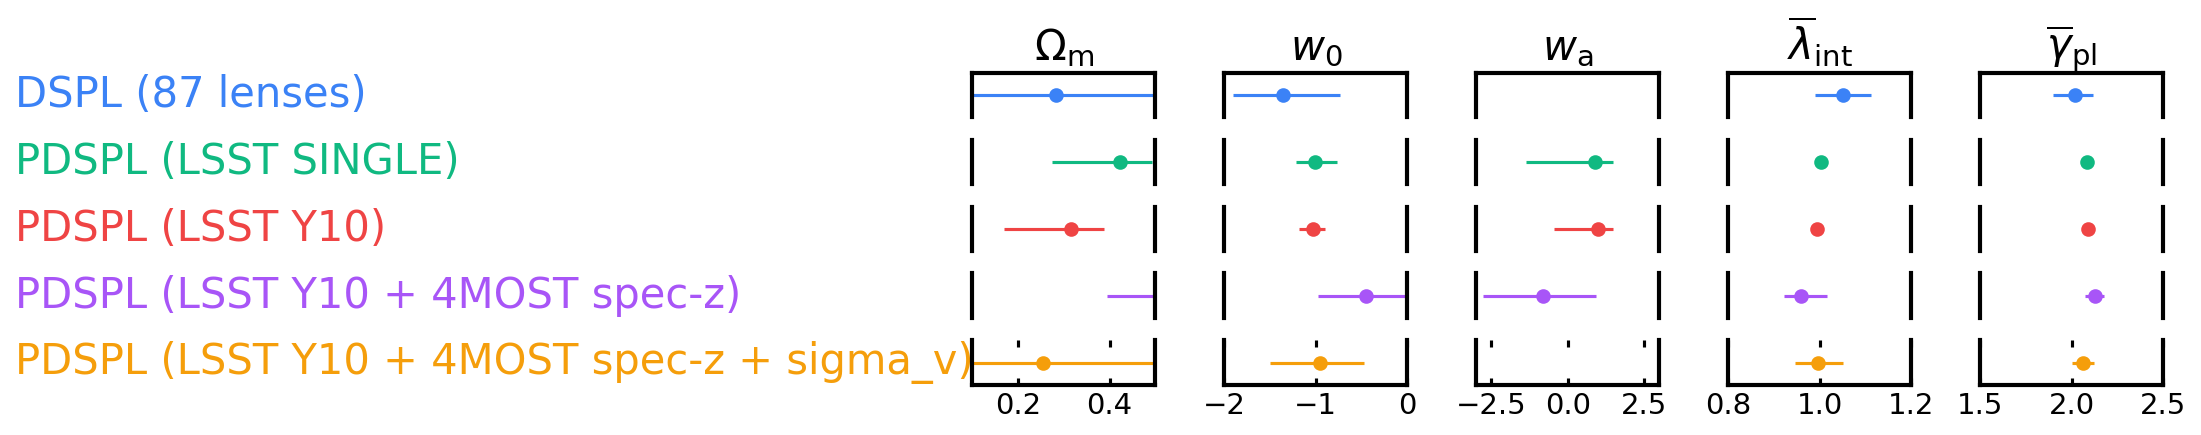

In [24]:
fig = consumer.plotter.plot_summary(errorbar=True);
fig.tight_layout()

In [25]:
latex_table = consumer.analysis.get_latex_table()
print(latex_table)

Parameter $w_{\rm a}$ in chain DSPL (87 lenses) is not constrained
Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


\begin{table}
    \centering
    \caption{}
    \label{tab:model_params}
    \begin{tabular}{cccccc}
        \hline
		Model & $\Omega_{\rm m}$ & $w_0$ & $w_{\rm a}$ & $\overline{\lambda}_{\rm int}$ & $\overline{\gamma}_{\rm pl}$ \\ 
		\hline
		DSPL (87 lenses) & $0.28^{+0.29}_{-0.20}$ & $-1.35^{+0.61}_{-0.55}$ &  & $1.051^{+0.061}_{-0.062}$ & $2.019^{+0.097}_{-0.121}$ \\ 
		PDSPL (LSST SINGLE) & $0.422^{+0.071}_{-0.149}$ & $-1.01^{+0.25}_{-0.21}$ & $0.91^{+0.57}_{-2.27}$ & $\left( 1003.6^{+7.1}_{-6.4} \right) \times 10^{-3}$ & $2.085^{+0.012}_{-0.011}$ \\ 
		PDSPL (LSST Y10) & $0.316^{+0.073}_{-0.147}$ & $-1.03^{+0.13}_{-0.16}$ & $1.00^{+0.50}_{-1.46}$ & $\left( 993.5^{+6.8}_{-7.5} \right) \times 10^{-3}$ & $\left( 2085.8^{+9.5}_{-9.3} \right) \times 10^{-3}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z) & $0.88^{+0.12}_{-0.48}$ & $-0.45^{+0.42}_{-0.53}$ & $-0.8^{+1.8}_{-2.0}$ & $0.959^{+0.056}_{-0.037}$ & $2.128^{+0.047}_{-0.056}$ \\ 
		PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) & $0.25^{+0.36

Parameter $w_{\rm a}$ in chain PDSPL (LSST Y10 + 4MOST spec-z + sigma_v) is not constrained


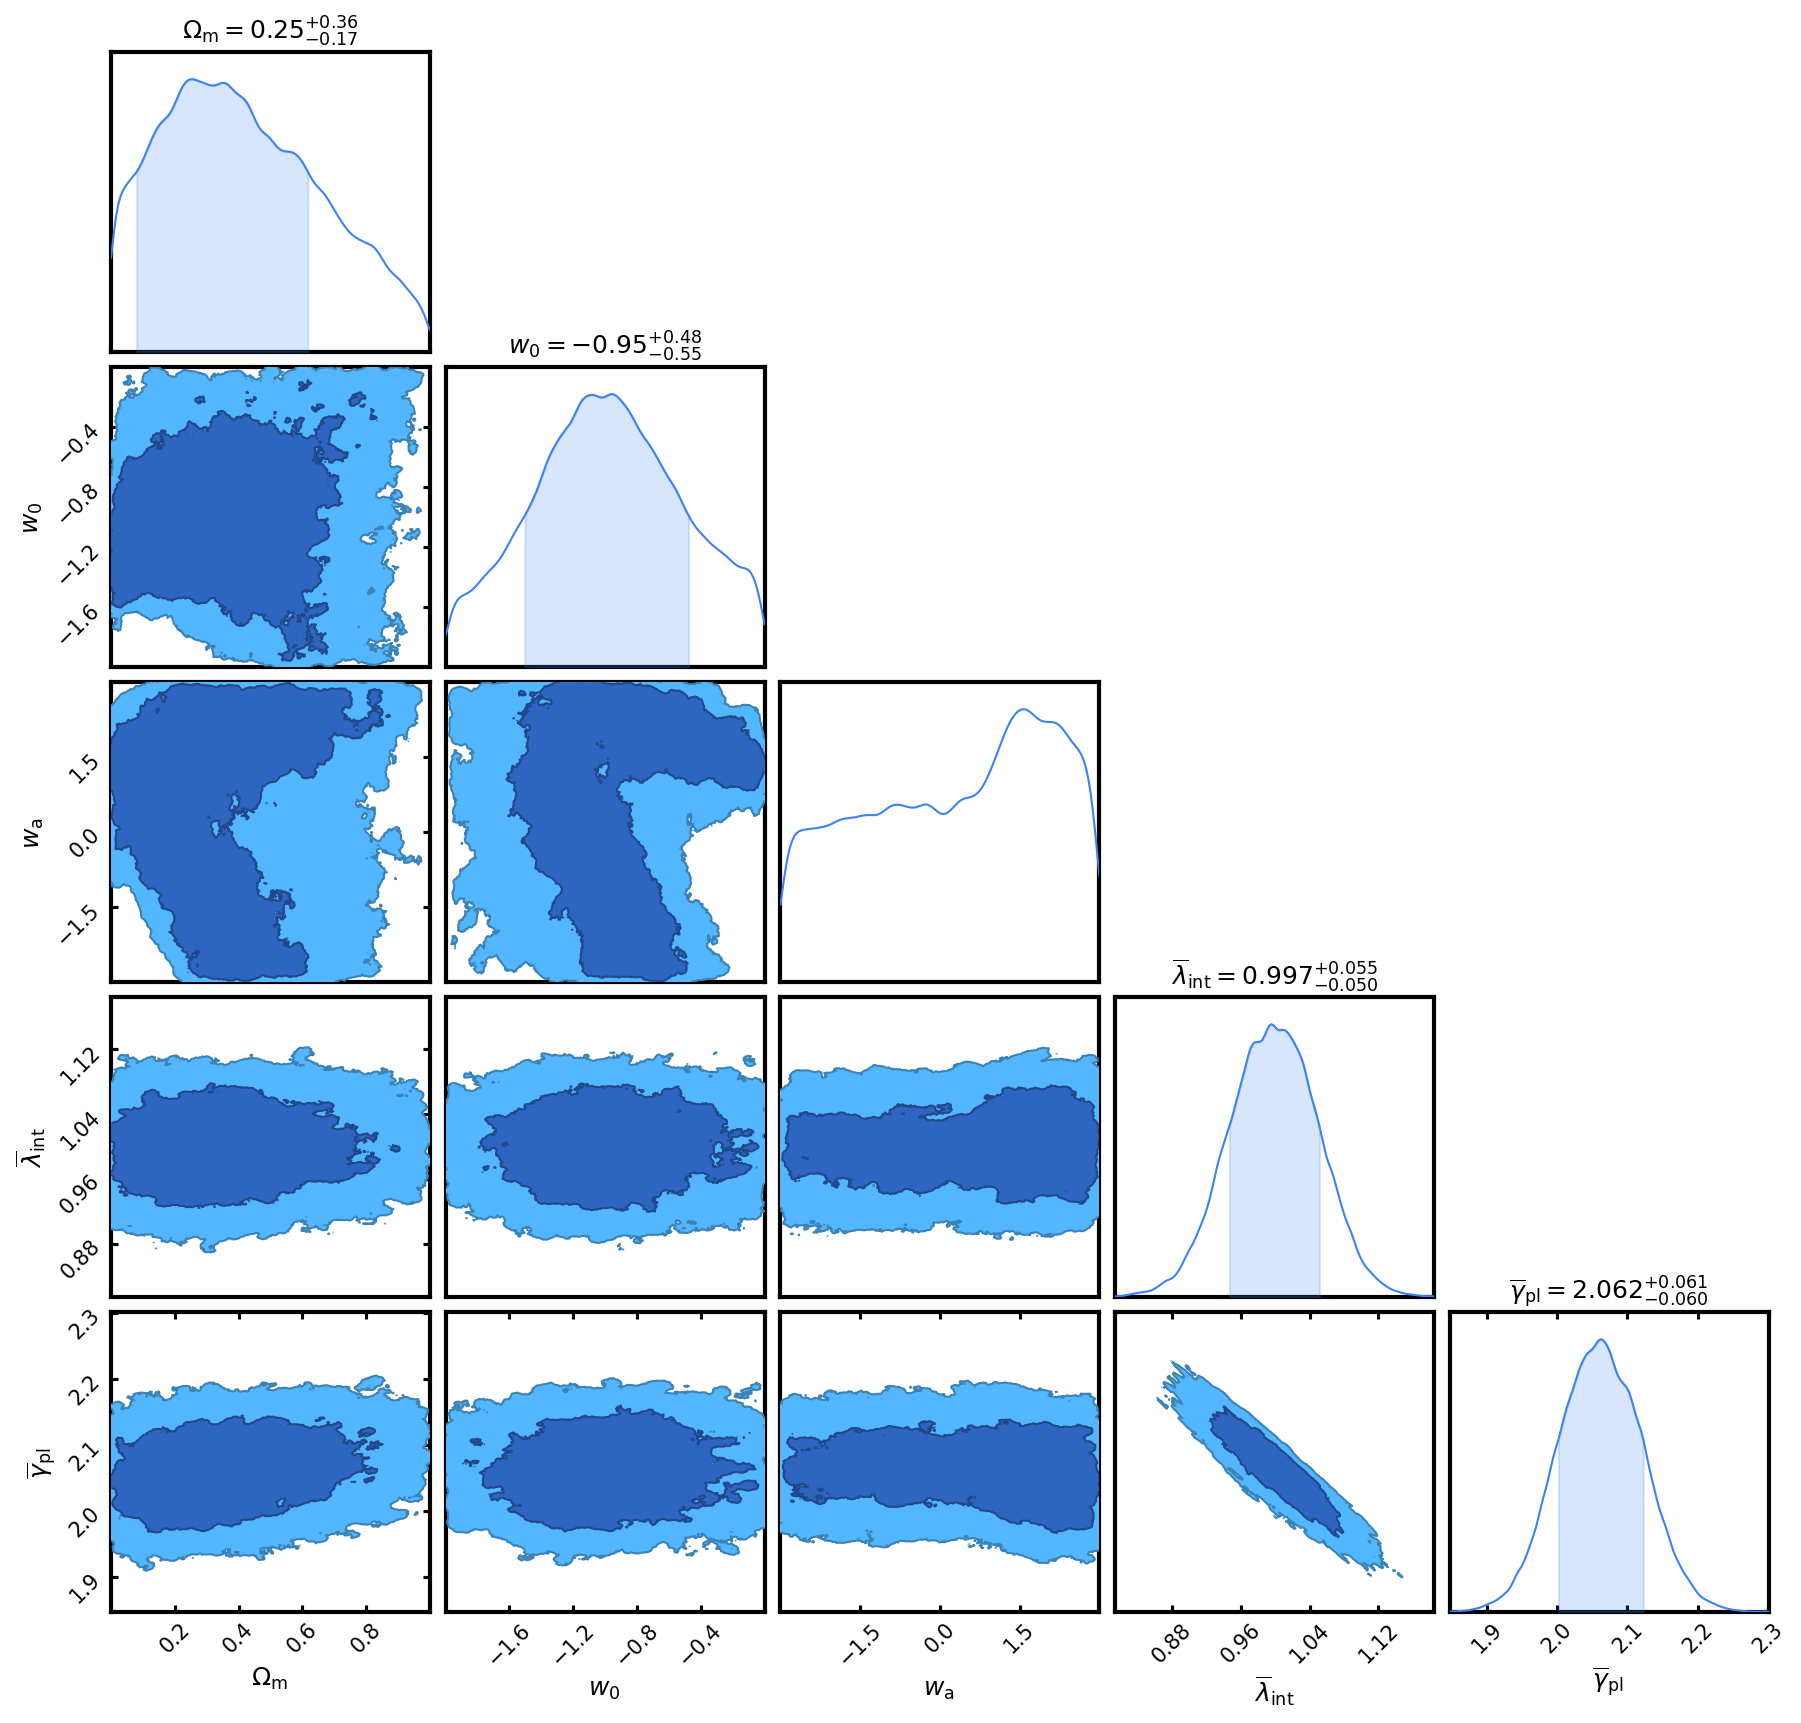

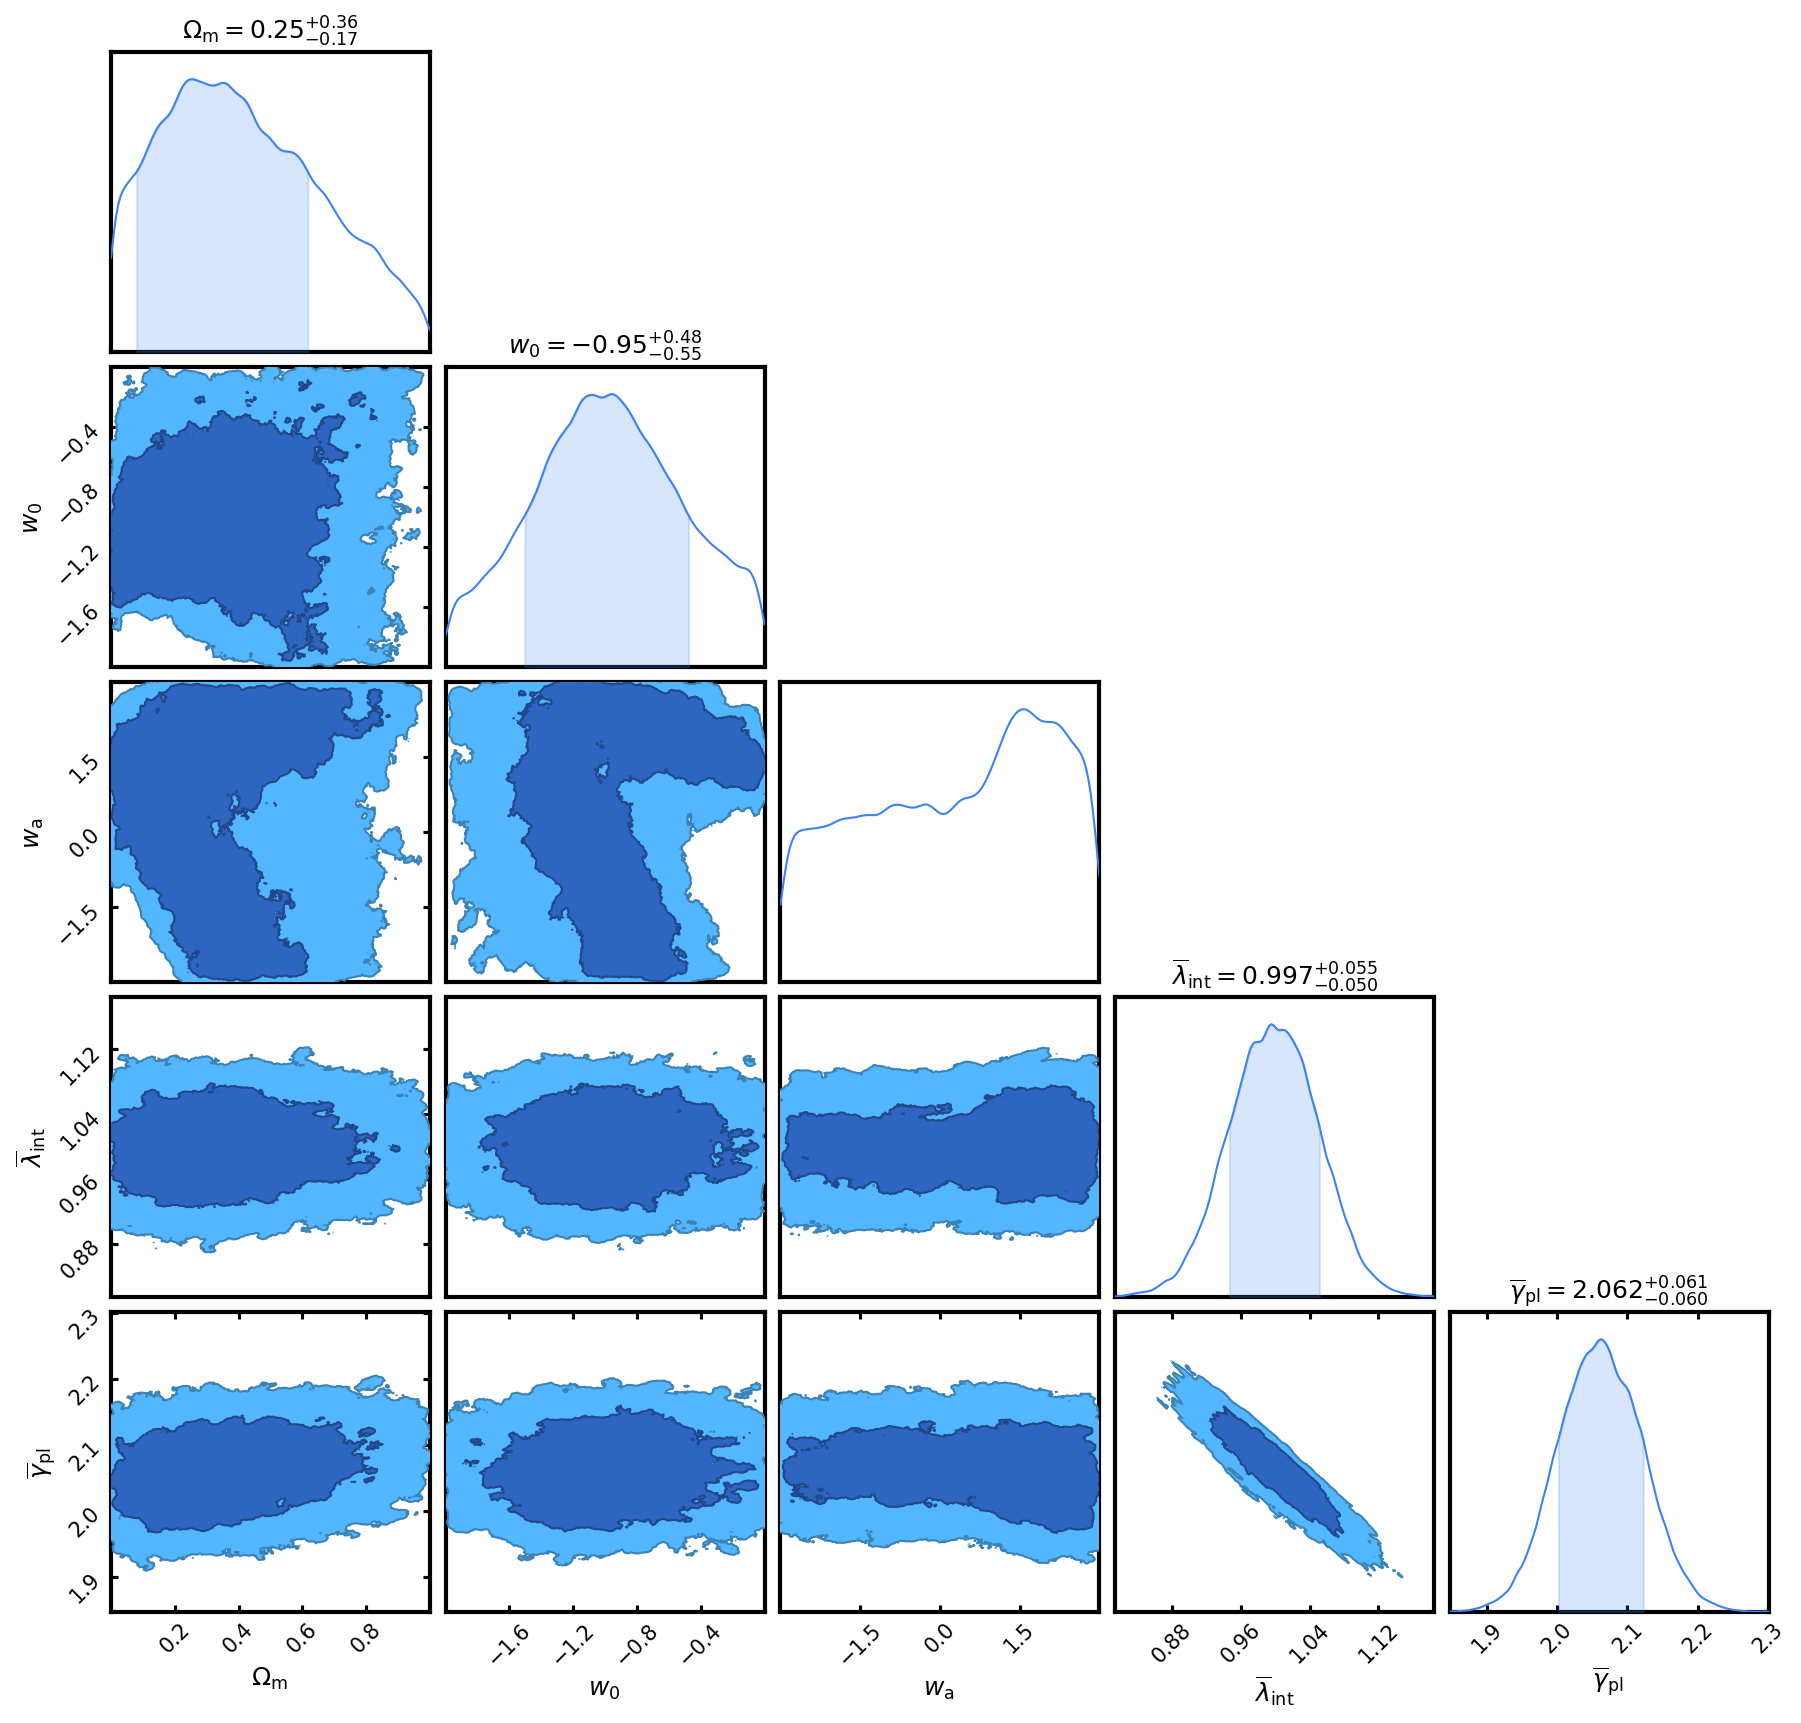

In [27]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_4most_spec-z_sigma_v']['ChainConsumer-Chain'])
consumer.plotter.plot()

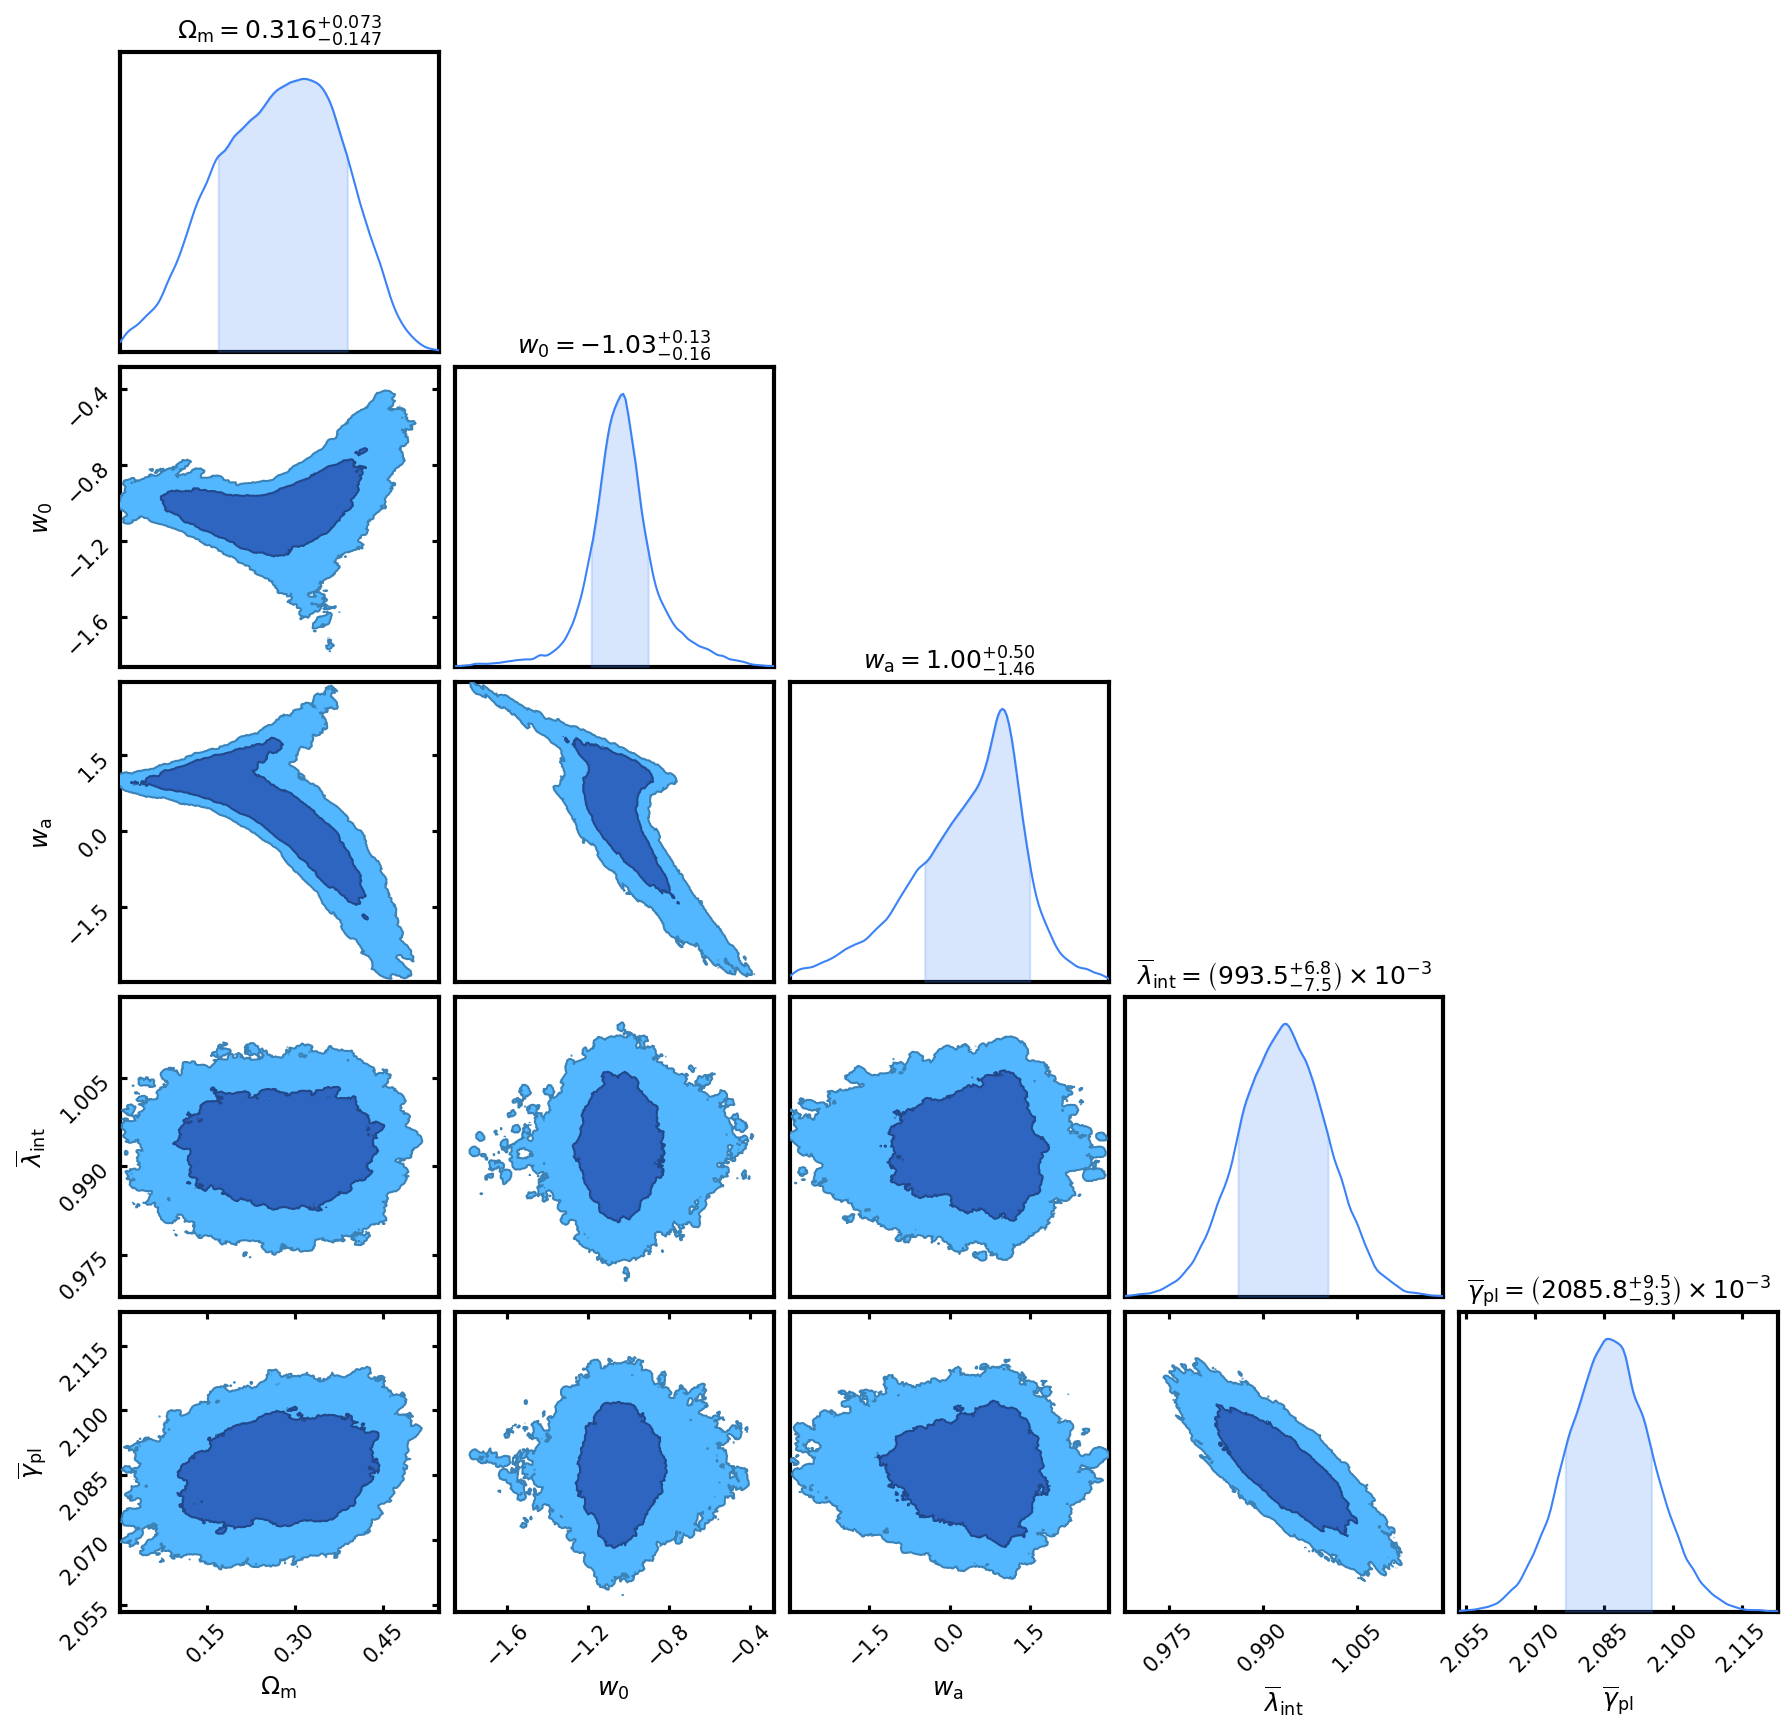

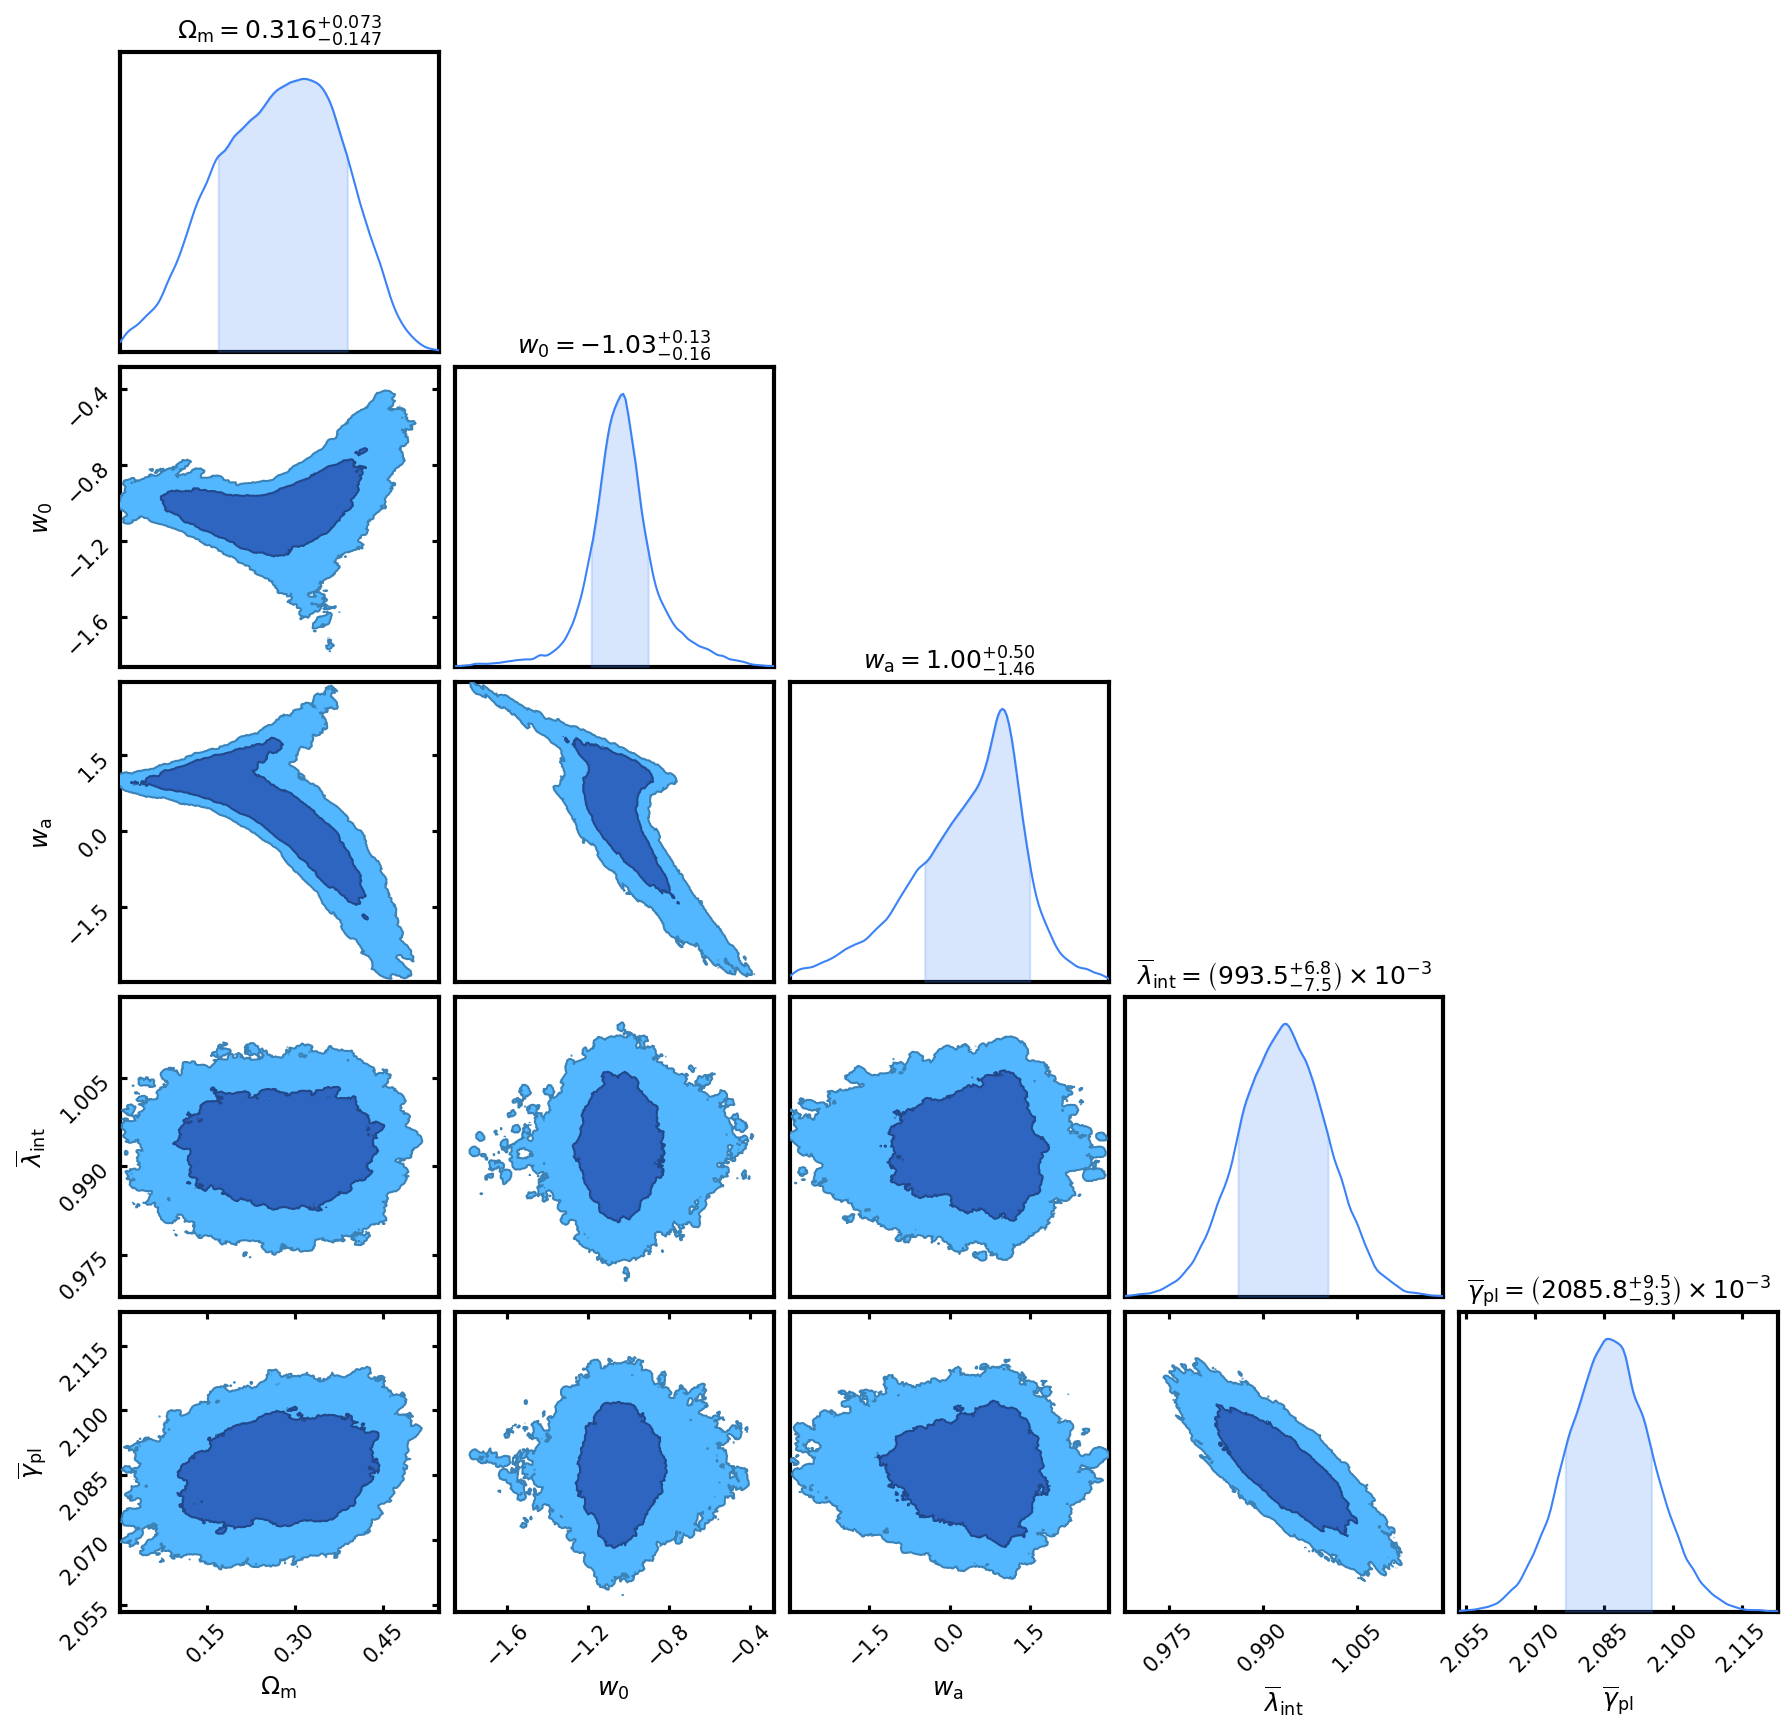

In [26]:
consumer = ChainConsumer()
consumer.add_chain(forecast_samples['lsst_y10']['ChainConsumer-Chain'])
consumer.plotter.plot()